## Pierson-Moskowitz Spectrum

The Pierson-Moskowitz energy desnity spectrum is:

$$S(\omega) = \frac{A_{sp}}{\omega^{5}}exp\bigg(-\frac{B_{sp}}{\omega^{4}}\bigg) $$

where $A_{sp}$ is:

$$A_{sp} = 8.1 \cdot 10^{-3} \cdot g^{2}$$

and

$$B_{sp} = \frac{3.11}{H_{s}^{2}} $$

and

$$H_{s} = 0.21 \frac{V^{2}}{g} $$

To calculate wave position, the frequency range is divided into parts. The following equation represents the harmonic wave spread:

$$s(t) = \sum_{i=1}^{N}s_{i} = \sum_{i=1}^{N}A_i \cdot \sin(\omega_{i}t + \phi_{i}) $$

$\phi_{i}$ is a random phase angle uniformly distributed and constant with time from 0 to $2\pi$.

$A_{i}$ is

$$ A_{i} = \sqrt{2 \cdot S(\omega_{i}) \cdot \Delta\omega} $$

$\Delta\omega$ is the length of the division of the spectral density function $S(\omega)$

In [6]:
import numpy as np
import control
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def sig_waveheight(V_knots, g):
    
    V = V_knots * 0.5144    # Conversion from knots to m/s
    H_s = 0.21 * (V**2 / g)
    
    return H_s

def energy_density(omega, A_sp, B_sp):
    x = -B_sp / omega**4
    S = (A_sp / omega**5) * np.exp(x)
    
    return S

def Amp(S, delta_omega):
    A = 2 * S * delta_omega
    A = np.sqrt(A)
    
    return A

def wave_spread(A_i, omega_i, g, t, phi_i):
    wave = A_i * (omega_i**2 / g) * np.sin(omega_i * t + phi_i)
    
    return wave


#     Declaration of variables
V_knots = 15.    # In knots
g = 9.81        # Gravity
N = 5           # Number of desired frequencies
t = np.linspace(0,60,6001)



#     Declaration of arrays to be used later
S_array = []
wave_array = []

#     Creates range of frequencies
start_omega = 0.2 
end_omega = 1.2
omega_range = np.linspace(start_omega, end_omega, N)
#     Delta_omega is length of the division of the spectral density function
delta_omega = omega_range[1] - omega_range[0]


#     Creates range of phase shifts
start_phi = 0
end_phi = 2*np.pi
phi_range = np.linspace(start_phi, end_phi, N)


counter = 0
while counter < (N):

    #     Calculates Significant Wave Height, A_sp, and B_sp values
    H_s = sig_waveheight(V_knots,g)
    A_sp = 8.1 * 10**-3 * g**2
    B_sp = 3.11 / H_s**2

    #     Pulls values of omega and phi from array according to counter
    omega_i = omega_range[counter]
    phi_i = phi_range[counter]

    #     Calculates energy density of wave per current omega value and stores in array
    S = energy_density(omega_i, A_sp, B_sp)
    if np.size(S_array) == 0:
        S_array = S
    else:
        S_array = np.vstack((S_array, S))

    #     Calculates A_i value that will be used in wave calculation
    A_i = Amp(S, delta_omega)

    #     Calculates total wave for current omega
    wave = wave_spread(A_i, omega_i, g, t, phi_i)

    #     Stores calculated wave in wave_array
    if np.size(wave_array) == 0:
        wave_array = wave
    else:
        wave_array = np.vstack((wave_array, wave))



    counter = counter + 1


counter = 0
total_wave = 0


#     Summation of waves found previously
while counter < N:
    total_wave = total_wave + wave_array[counter,:]

    counter = counter + 1


## Calculation of translatory forces and roll torque

The following equations utilize the information found in the previous section to calculate translatory forces $F_{x}$ and $F_{y}$, as well as the roll torque, $M_{z}$.

The equations for translatory forces are as follows:

$$F_{x}(t) = \sum_{i=1}^{N} \bar{\rho} \cdot T_{S} \cdot \cos(\beta) \cdot s_{i}(t) $$

and

$$F_{y}(t) = \sum_{i=1}^{N} -\bar{\rho} \cdot T_{S} \cdot \sin(\beta) \cdot s_{i}(t) $$

where

$$ \bar{\rho} = \rho \cdot g \cdot B_{S} \cdot L_{S} $$

$\rho$ is the volume density of water, $B_{S}$ and $L_{S}$ are the width and length of the ship. $T_{S}$ is the depth of floatation and $\beta$ is the angle under which waves hit the ship.

The roll torque is given by the following:

$$ M_{z}(t) = \sum_{i=1}^{N} \frac{1}{24} \cdot \bar{\rho} \cdot (L_{S}^{2} - B_{S}^{2}) \cdot \sin(2\beta) \cdot s_{i}^{2}(t) $$

In [8]:
rho = 1027.     # Density in kg/m^3
B_S = 2.2        # Width of ship in meters
L_S = 5.        # Length of ship in meters
T_S = .981       # Depth of flotation in meters

# start_beta = 0  # Angle that wave hits boat TODO: Include range of angles
# end_beta = 180
# N_beta = 7      # Number of differing angles to be used
# beta_range = np.linspace(start_beta, end_beta, N_beta)

total_F_x = []
total_F_y = []
total_M_z = []

rho_bar = rho * g * B_S * L_S

#   Angle in which wave encounters vessel
beta = np.radians(15)

omega_counter = 0
while omega_counter < N:
    F_x = rho_bar * T_S * np.cos(beta) * wave_array[omega_counter,:]
    F_y = -rho_bar * T_S * np.sin(beta) * wave_array[omega_counter,:]
    M_z = (1./24.) * rho_bar * (L_S**2 - B_S**2) * np.sin(2*beta) * wave_array[omega_counter,:]



    if np.size(total_F_x) == 0:
        total_F_x = F_x
        total_F_y = F_y
        total_M_z = M_z
    else:
        total_F_x = total_F_x + F_x
        total_F_y = total_F_y + F_y
        total_M_z = total_M_z + M_z


    omega_counter = omega_counter + 1

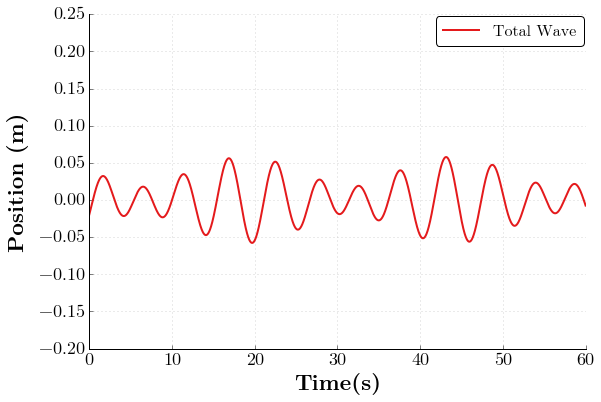

In [9]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),family='Serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='Serif',fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

plt.xlabel(r'Time(s)',family='Serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel(r'Position (m)',family='Serif',fontsize=22,weight='bold',labelpad=10)

plt.plot(t, total_wave, linewidth=2, linestyle = '-',   label=r'Total Wave')

# plt.xlim(0,1.6)
plt.ylim(-0.2,0.25)

leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts() 
plt.setp(ltext,family='Serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# If you want to save the figure, uncomment the commands below. 
# The figure will be saved in the same directory as your IPython notebook.
# Save the figure as a high-res pdf in the current folder
# plt.savefig('{}_frequency_wave.pdf'.format(N),dpi=600)

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook
plt.show()

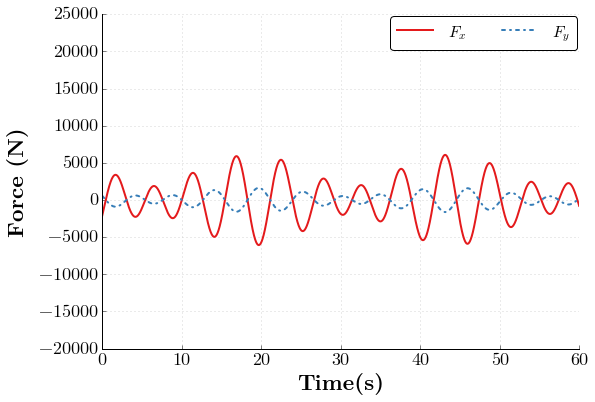

In [10]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),family='Serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='Serif',fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

plt.xlabel(r'Time(s)',family='Serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel(r'Force (N)',family='Serif',fontsize=22,weight='bold',labelpad=10)

plt.plot(t, total_F_x, linewidth=2, linestyle = '-',   label=r'$F_{x}$')
plt.plot(t, total_F_y, linewidth=2, linestyle = '-.',   label=r'$F_{y}$')
   
# plt.xlim(0,1.6)
plt.ylim(-20000,25000)

leg = plt.legend(loc='upper right', fancybox=True, ncol=2)
ltext  = leg.get_texts() 
plt.setp(ltext,family='Serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# If you want to save the figure, uncomment the commands below. 
# The figure will be saved in the same directory as your IPython notebook.
# Save the figure as a high-res pdf in the current folder
# plt.savefig('{}_frequency_wave_forces.pdf'.format(N),dpi=600)

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook
plt.show()
